# Practice - SAR Linear Regression

## Spatially Adjusted Regression - Linear Regression

Ordinary Least Squares vs Spatial Simultaneous Autoregressive Models

In this practice, it is assumed that we are working under the normal probability model. The goals of this practice are to:

a) evaluate a standard OLS regression using a continuous dependent variable when spatial autocorrelation may be present, and 

b) evaluate the same relationships given the ability to adjust for spatial autocorrelation using the rho term obtained from a simultaneous autoregressive error model.

### Load relevant libraries

Documentation for the R libraries used in this notebook can be found at: 
   
  
  - [rgdal library](https://web.dsa.missouri.edu/static/PDF/R/rgdal.pdf)   
  
  - [classInt library](https://web.dsa.missouri.edu/static/PDF/R/classInt.pdf)
  
  - [spdep library](https://web.dsa.missouri.edu/static/PDF/R/spdep.pdf)
  
  - [RColorBrewer library](https://web.dsa.missouri.edu/static/PDF/R/RColorBrewer.pdf)
  
  - [geoR library](https://web.dsa.missouri.edu/static/PDF/R/geoR.pdf)
  
  - [car library](https://web.dsa.missouri.edu/static/PDF/R/car.pdf)
  
  - [MASS library](https://web.dsa.missouri.edu/static/PDF/R/MASS.pdf)

In [1]:
## Load relevant R packages.
inLibraries = list('repr','rgdal','spdep','spatialreg','classInt','car','RColorBrewer','MASS','geoR')
for (rpack in inLibraries) {
  if (is.element(rpack,installed.packages()[,1])){           
      #Load the library into R
      suppressMessages(library(rpack,character.only = TRUE))
    }
    else {
        print(paste("Warning:  ",rpack," is not an installed package"))
    }
}

## Resize plot area.
options(repr.plot.width=6, repr.plot.height=6)

## US Farming Data

In this practice, we will be working with county data on agricultural practices in the USA (usagriculture/usfarming.shp). Elements of this dataset were obtained from the 2012 [US Ag. Census](https://web.dsa.missouri.edu/static/PDF/R/Ag_Census_Map_documentation_07172015.pdf) ; External source: https://agcensus.library.cornell.edu/census_year/2012-census/. The fields in this dataset may seem kinda mystical, but they are documented in depth at the website noted above (download the associated [Ag. Census Excel](https://web.dsa.missouri.edu/static/PDF/R/Ag_Census_Map_data_07172015.xlsx).

There is also a field in the ag. census polygons named 'GRIDCODE', which reflects mean annual precipitation between 1990 and 2009 for each county. The original precipitation data was obtained from (USGS United States Average Annual Precipitation 1990-2009, data can be found at - External source: https://data.globalchange.gov/dataset/usgs-united-states-average-annual-precipitation-1990-2009). The precip. data were then spatially joined to the county polygons.

Note: By all means, this is not really a large dataset (3070 records), however, since all operations will be conducted on a remote server, the size of the data coupled with the complexity of the methods could result in longer times required to obtain the results for each step.

First, read in the county level data.

In [2]:
## Read in the featureclass.
#inFeatures <- readOGR("/dsa/data/geospatial/DS8612/usagriculture","usfarming",GDAL1_integer64_policy=TRUE)
inFeatures <- readOGR(dsn="C:/Users/ja2qm/MIZZOU/_MotherFolderAmanWorks/Aman thesis works/_1_FinalTopic/_CAADRIA2022/Paper_2/SensingTheCity_Stat_R_TimScript/Script from Tim/usfarmsdata", layer="usfarming")

OGR data source with driver: ESRI Shapefile 
Source: "C:\Users\ja2qm\MIZZOU\_MotherFolderAmanWorks\Aman thesis works\_1_FinalTopic\_CAADRIA2022\Paper_2\SensingTheCity_Stat_R_TimScript\Script from Tim\usfarmsdata", layer: "usfarming"
with 3070 features
It has 93 fields
Integer64 fields read as strings:  Join_Count TARGET_FID cntyn ID GRIDCODE 


## Subset Features

As agricultural conditions vary considerably over the U.S., let's select a specific state to analyze - California.

Note, that state names are not explicitly included in the dataset. However, the FIPS (Federal Information Processing Specification) code for each county is provided. Typically, the first two digits of a FIPS code reflect the state id number while the last three reflect a specific county within a state.  In this dataset, the 'atlas_stco' field contains the FIPS code as a character variable. Thus, in order to select the first two characters associated with a particular state, we need some way to match one portion of a string to another. There are several ways to do this. In this case, first a new field is added to the dataframe 'stcode' and populated with the first two characters in the 'atlas_stco' field which is the FIPS code. Next, grep() is used to select the FIPS code prefixes which correspond with the FIPS code of California ('06').

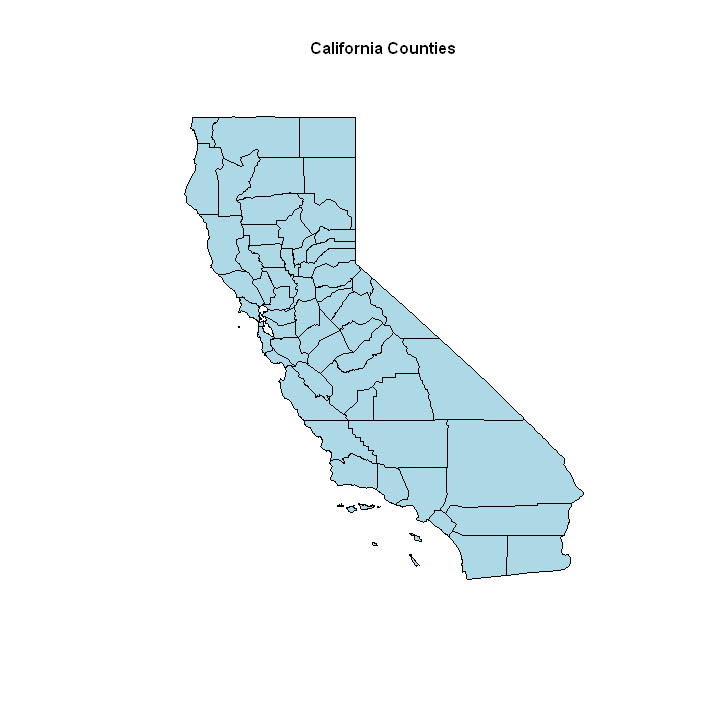

In [3]:
## Add new column to data frame and populate with first two numbers of FIPS code.
inFeatures@data$stcode <- substr(inFeatures@data$atlas_stco, start=1, stop=2)

## Select features with a state fips code beginning with...
inFeaturesSubsetA <- inFeatures[grep("06", inFeatures@data$stcode), ]

## Plot the state selected.
plot(inFeaturesSubsetA,col="lightblue", lwd=.2, main="California Counties",cex.main=.8)

## Generate Neighborhoods for Features

Generate neighborhoods for each feature according to the Queen's Criterion.  Then test the neighborhoods to see if they are valid.  Retain only the features with valid neighborhoods.

In [4]:
## Identify the neighbors of each feature.
inFeaturesSubsetA.nb <- poly2nb(inFeaturesSubsetA ,queen=TRUE)

## Select features with at least one neighbor.
inFeaturesSubset <- inFeaturesSubsetA[card(inFeaturesSubsetA.nb) >= 1, ]

## Identify the neighbors of each feature having at least one neighbor.
inFeaturesSubset.nb <- poly2nb(inFeaturesSubset, queen=TRUE)

## Create a binary weighted neighbors list
inFeaturesSubset.listb <- nb2listw(inFeaturesSubset.nb,style="B")
## Create a row standardized weighted neighbors list
inFeaturesSubset.listw <- nb2listw(inFeaturesSubset.nb,style="W")

## Analysis Variables

Configure the variables to analyze. 

In this practice, the dependent variable is 'y12_M082_1' (acres of irrigated land as percent of land in farms acreage (year 2012)) and the explanatory variable will be 'GRIDCODE' (mean annual rainfall 1990-2009). 

In [5]:
## Response variable.
YVar <- inFeaturesSubset$y12_M082_1

## Explanatory variable.
EXVar <- inFeaturesSubset$GRIDCODE

## Examine Characteristics of Variables

Produce a scatterplot of the dependent variable (y-axis) and the explanatory variable (x-axis). What can be observed? Well, it seems that there is some trend manifesting here. The Shapiro test however indicates the dependent variable is likely not normal as the null hypothesis can be rejected. Although that's not a huge concern at this point, the dependent variable can be transformed to make it more linear.


	Shapiro-Wilk normality test

data:  YVar
W = 0.91452, p-value = 0.0005848


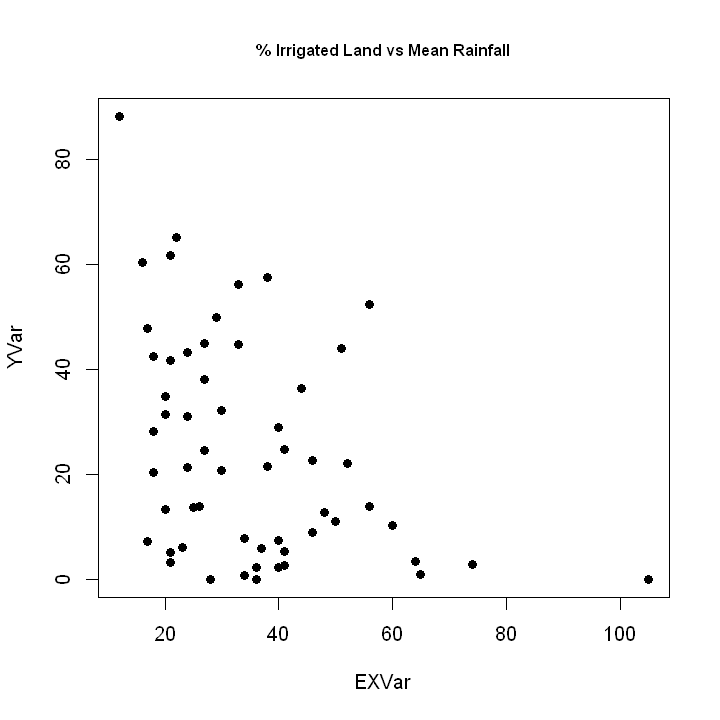

In [6]:
## Scatter plot of model variables.
plot(EXVar,YVar,pch=19,main="% Irrigated Land vs Mean Rainfall",cex.main=.8)

## Conduct a shapiro test.
shapiro.test(YVar)

Remember, the individual components of the test statistic can be accessed as well.  Take a look at the structure of the test statistic output (i.e., str()).

In [ ]:
#Evaluate structure of test statistic result.
str(shapiro.test(YVar))

Thus, the individual components of the test statistic results can be accessed as we did in earlier modules.

In [7]:
#Access statistic attribute by name.
print(shapiro.test(YVar)$statistic)

#Access statistic attribute by index.
print(shapiro.test(YVar)[1])

        W 
0.9145197 
$statistic
        W 
0.9145197 



### Transform the Dependent Variable

Here, the dependent variable is powered to adjust the distribution.

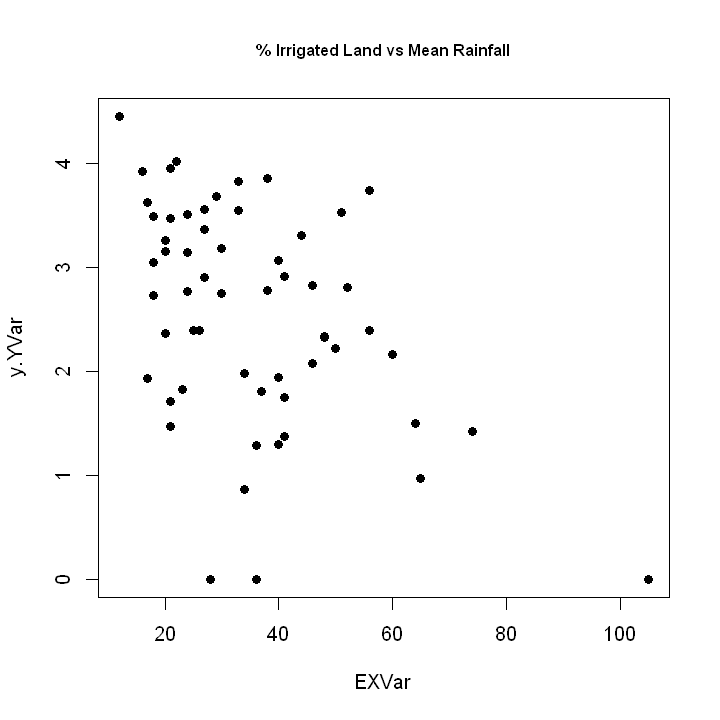

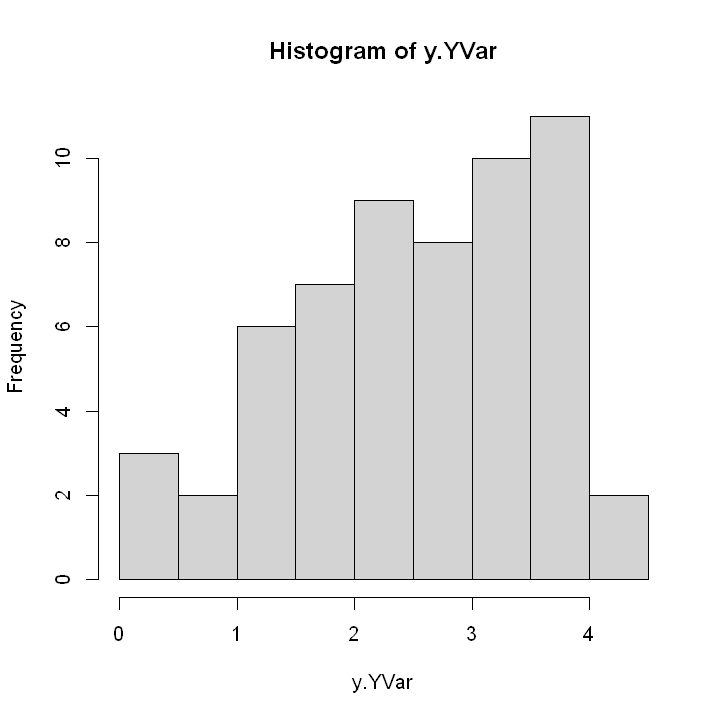

In [8]:
### Power transformation applied.
lambdapwr <- (1/3)
y.YVar <- YVar^(lambdapwr)

## Scatterplot of model variables.
plot(EXVar,y.YVar,pch=19,main="% Irrigated Land vs Mean Rainfall",cex.main=.8)

## Histogram of dependent variable.
hist(y.YVar)

### Shapiro Test

Test the dependent variable again and produce a Q-Q plot.  This time it looks like the null hypothesis is not as easily rejected. Feel free to experiment with the transformation and investigate whether a better transformation can be found. If you do find a better transformation, post it to the discussion page!

In [9]:
## Shapiro test.
shapiro.test(y.YVar)
shapiro.test(EXVar)

## Default S3 method:
qqnorm(y.YVar, main = "Normal Q-Q Plot",
       xlab = "Theoretical Quantiles", ylab = "Sample Quantiles",
       plot.it = TRUE, datax = FALSE)

qqline(y.YVar, datax = FALSE)

qqplot(EXVar, y.YVar, plot.it = TRUE, xlab = deparse(substitute(x)),
       ylab = deparse(substitute(y.YVar)))


	Shapiro-Wilk normality test

data:  y.YVar
W = 0.95843, p-value = 0.04502


ERROR: Error in shapiro.test(EXVar): is.numeric(x) is not TRUE


# Normal Probability Models

## Regular (OLS) Regression

Let's first conduct a OLS linear regression.  

Remember, OLS can be called using R's lm() function.  After the function is applied, the resid() function can be called to retrieve the modeled residuals.  Test the residuals to see if normality can be accepted...looks good to me.

In [10]:
## Simple OLS.
YVar.lm <- lm(y.YVar ~ EXVar)

## OLS summary.
summary(YVar.lm)

## Shapiro test.
shapiro.test(resid(YVar.lm))


Call:
lm(formula = y.YVar ~ EXVar)

Residuals:
    Min      1Q  Median      3Q     Max 
-1.1798 -0.2529  0.0000  0.2211  1.3008 

Coefficients:
              Estimate Std. Error t value Pr(>|t|)    
(Intercept) -2.128e-15  7.527e-01   0.000 1.000000    
EXVar12      4.452e+00  1.065e+00   4.182 0.000332 ***
EXVar16      3.925e+00  1.065e+00   3.687 0.001156 ** 
EXVar17      2.781e+00  9.219e-01   3.016 0.005971 ** 
EXVar18      3.088e+00  8.692e-01   3.553 0.001616 ** 
EXVar20      2.929e+00  8.692e-01   3.370 0.002536 ** 
EXVar21      2.650e+00  8.416e-01   3.149 0.004341 ** 
EXVar22      4.023e+00  1.065e+00   3.779 0.000918 ***
EXVar23      1.827e+00  1.065e+00   1.716 0.098964 .  
EXVar24      3.142e+00  8.692e-01   3.615 0.001384 ** 
EXVar25      2.391e+00  1.065e+00   2.246 0.034167 *  
EXVar26      2.398e+00  1.065e+00   2.253 0.033693 *  
EXVar27      3.276e+00  8.692e-01   3.769 0.000943 ***
EXVar28      2.845e-15  1.065e+00   0.000 1.000000    
EXVar29      3.681e+00  1.065e


	Shapiro-Wilk normality test

data:  resid(YVar.lm)
W = 0.9584, p-value = 0.04486


### Test Residuals for Autocorrelation

Next, test the residuals for presence of spatial autocorrelation.  How can this result be interpreted? Perhaps there is some autocorrelation at work in the residuals. If that's the case, then the assumptions of OLS have been violated.

In [11]:
## Retrieve residuals.
YVar.lm.res <- residuals(YVar.lm)

## Apply Moran test.
moran.test(YVar.lm.res, inFeaturesSubset.listb)


	Moran I test under randomisation

data:  YVar.lm.res  
weights: inFeaturesSubset.listb    

Moran I statistic standard deviate = -1.0492, p-value = 0.853
alternative hypothesis: greater
sample estimates:
Moran I statistic       Expectation          Variance 
     -0.102001511      -0.017543860       0.006479581 


## Spatial Simultaneous Autoregressive (SAR) Model

The SAR specification builds upon the OLS specification in that it accounts for the spatial weights among the features (row standardized - W) as an explanatory variable and estimates a coefficient for spatial autocorrelation (rho). The errorsarlm() function (spdep library) can be applied to specify a SAR model. 

The syntax for errorsarlm() is:

    errorsarlm(formula, data=list(), listw, na.action, weights=NULL,
    etype="error", method="eigen", quiet=NULL, zero.policy=NULL,
    interval = NULL, tol.solve=1.0e-10, trs=NULL, control=list())


The errorsarlm() function requires the dependent and independent variables in the form of a 'formula' as well as the neighborhood list 'listw'.

Conduct the SAR analysis below.  Are there any indications of positive spatial autocorrelation?  Does the SAR model improve upon the amount of variance that is accounted for? How can you tell?

Note that the standard errors in the OLS specification are lower than in the SAR specification. This shows that not accounting for spatial autocorrelation makes the OLS results falsely appear to be stronger than they really are!

Finally, examine normality of the residuals. There is still an indication of non-normality, but not as extreme as before.

In [12]:
## SAR model.
YVar.sar1 <- errorsarlm(y.YVar ~ EXVar, listw=inFeaturesSubset.listw)

## Summary of SAR model.
summary(YVar.sar1)

## obtain the model residuals.
YVar.sar1.res <- residuals(YVar.sar1)

## Conduct the Shapiro test.
shapiro.test(YVar.sar1.res)


Call:errorsarlm(formula = y.YVar ~ EXVar, listw = inFeaturesSubset.listw)

Residuals:
       Min         1Q     Median         3Q        Max 
-0.9246524 -0.2126271 -0.0066447  0.1860870  0.7586210 

Type: error 
Coefficients: (asymptotic standard errors) 
            Estimate Std. Error z value  Pr(>|z|)
(Intercept) -0.33441    0.70907 -0.4716 0.6372040
EXVar12      5.36329    0.87235  6.1481 7.840e-10
EXVar16      4.75914    0.84742  5.6160 1.954e-08
EXVar17      3.30241    0.79653  4.1460 3.383e-05
EXVar18      3.02333    0.73930  4.0895 4.324e-05
EXVar20      3.62823    0.77236  4.6976 2.633e-06
EXVar21      3.34599    0.72292  4.6285 3.684e-06
EXVar22      4.67046    0.81064  5.7615 8.338e-09
EXVar23      1.82041    0.86265  2.1103 0.0348358
EXVar24      3.42762    0.74094  4.6260 3.727e-06
EXVar25      3.50129    0.85342  4.1027 4.084e-05
EXVar26      2.89931    0.85789  3.3796 0.0007259
EXVar27      3.00950    0.71056  4.2354 2.282e-05
EXVar28      0.10325    1.19584  0.0863 0.9


	Shapiro-Wilk normality test

data:  YVar.sar1.res
W = 0.98097, p-value = 0.4941


### Test Residuals for Autocorrelation

Test the SAR residuals for presence of spatial autocorrelation.  How does this result differ from the Moran test applied to the OLS residuals?

In [13]:
## Apply Moran test to SAR residuals.
moran.test(YVar.sar1.res, inFeaturesSubset.listb)


	Moran I test under randomisation

data:  YVar.sar1.res  
weights: inFeaturesSubset.listb    

Moran I statistic standard deviate = -2.1314, p-value = 0.9835
alternative hypothesis: greater
sample estimates:
Moran I statistic       Expectation          Variance 
     -0.189482356      -0.017543860       0.006507813 


### Visualize the Fitted Values (SAR) Model

Visualize the fitted SAR values, being sure that the values are back-transformed into their original measurement units prior to mapping.

#### Back-Transformation

Back-transformation is the process of reversing a transformation that was previously applied to a dataset.  

Recall that earlier we transformed 'Y.Var' by powering to 'lambdapwr' (which was 1/3 in the earlier example).  To back-transform the fitted values, we will therefore need to power them to 1/'lambdapwr' (e.g., 1/(1/3) per our earlier example.

In [14]:
## Back-transform fitted values into original measurement units.
bt.YVar.sar1 <- YVar.sar1$fitted^(1/lambdapwr)

Now, map the back-transformed fitted values.

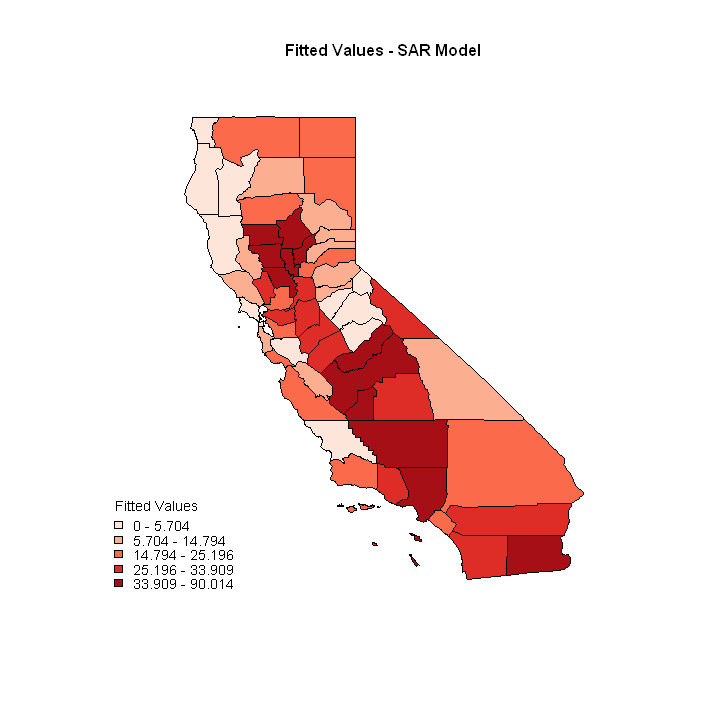

In [15]:
## Classify the variable.
numcat <- 5
cate <- classIntervals(bt.YVar.sar1, numcat, style="quantile")

## Assign colors to categories.
pal <- brewer.pal(numcat,"Reds")
cols <- findColours(cate,pal)

## Visualize fitted SAR values.
plot(inFeaturesSubset, col=cols, lwd=.2,main="Fitted Values - SAR Model",cex.main=.8)
brks <- round(cate$brks,3)
leg <- paste(brks[-(numcat+1)], brks[-1], sep=" - ")
legend("bottomleft", fill=pal, legend=leg, bty="n",title="Fitted Values",cex=.7)

### Examine Correlation Among the Variables

Next, examine the correlation between the dependent and independent variables using the Pearson Correlation Coefficient. This can be done using R's corr() function. As can be observed, the correlation is negative, meaning that as one variable increases, the other decreases. However, given that spatial autocorrelation was detected in the model, this is suspect and can indicated that spatial autocorrelation is affecting the variables themselves. Given this, we can now examine each of the variables for spatial autocorrelation.

In [16]:
## Calculate Pearson product moment correlation coefficient.
paste("Pearson Correlation = ",cor(y.YVar, EXVar))

ERROR: Error in cor(y.YVar, EXVar): 'y' must be numeric


## Estimate SAR Model for Each Variable

This time, let's apply a SAR model to both variables (dependent and explanatory) individually and simply examine the impact of the spatial weights. The rho or lambda parameter estimated by the SAR models can then be returned. Note that for both variables, rho (lambda) is significant, indicating spatial autocorrelation is at work in both of the variables.

In [17]:
## Estimate SAR autocorrelation parameter for Y variable.
YVar.sar2 <- errorsarlm(y.YVar ~ 1, listw=inFeaturesSubset.listw)
summary(YVar.sar2)
paste("Lambda = ",YVar.sar2$lambda)


## Estimate SAR autocorrelation parameter for X variable.
EXVar.sar2 <- errorsarlm(EXVar ~ 1, listw=inFeaturesSubset.listw)
summary(EXVar.sar2)
paste("Lambda = ",EXVar.sar2$lambda)


Call:errorsarlm(formula = y.YVar ~ 1, listw = inFeaturesSubset.listw)

Residuals:
      Min        1Q    Median        3Q       Max 
-2.275816 -0.504825  0.065455  0.802696  1.654604 

Type: error 
Coefficients: (asymptotic standard errors) 
            Estimate Std. Error z value  Pr(>|z|)
(Intercept)  2.45312    0.25868  9.4831 < 2.2e-16

Lambda: 0.52368, LR test value: 8.6178, p-value: 0.0033289
Asymptotic standard error: 0.13537
    z-value: 3.8685, p-value: 0.00010951
Wald statistic: 14.965, p-value: 0.00010951

Log likelihood: -80.66485 for error model
ML residual variance (sigma squared): 0.88059, (sigma: 0.9384)
Number of observations: 58 
Number of parameters estimated: 3 
AIC: 167.33, (AIC for lm: 173.95)


[1] "Lambda =  0.523675003102959"


Call:errorsarlm(formula = EXVar ~ 1, listw = inFeaturesSubset.listw)

Residuals:
     Min       1Q   Median       3Q      Max 
-18.0039  -5.8424  -0.8200   5.3788  46.7737 

Type: error 
Coefficients: (asymptotic standard errors) 
            Estimate Std. Error z value  Pr(>|z|)
(Intercept)  36.0551     7.4367  4.8483 1.245e-06

Lambda: 0.82284, LR test value: 46.691, p-value: 8.3095e-12
Asymptotic standard error: 0.069927
    z-value: 11.767, p-value: < 2.22e-16
Wald statistic: 138.46, p-value: < 2.22e-16

Log likelihood: -222.5678 for error model
ML residual variance (sigma squared): 100.68, (sigma: 10.034)
Number of observations: 58 
Number of parameters estimated: 3 
AIC: 451.14, (AIC for lm: 495.83)


[1] "Lambda =  0.822835274234041"

### Adjust Variables for Spatial Autocorrelation

Use the rho (lambda) parameters estimate above to adjust the dependent and explanatory variables for autocorrelation. This task can be accomplished is illustrated below. Basically, the dependent and independent variables are adjusted by subtracting them by the product of rho (lambda) and the spatial weights matrix (as a lag vector). The lag vector can be created using the lag.listw() function ('spdep' library). After the adjustment is made, re-assess the correlation between the adjusted variables. 

Note that after adjusting for spatial autocorrelation in each variable, the correlation is very much reduced from that computed earlier based on the unadjusted variables. Therefore, it is clear that if spatial autocorrelation was not accounted for, the correlation would appear to be much higher than it actually is.

In [18]:
## Adjust for spatial autocorrelation.
YVar.sa <- y.YVar - YVar.sar2$lambda * lag.listw(inFeaturesSubset.listw,y.YVar)
EXVar.sa <- EXVar - EXVar.sar2$lambda * lag.listw(inFeaturesSubset.listw,EXVar)

## Recompute adjusted Pearson product moment correlation coefficient.
cor(YVar.sa,EXVar.sa)

ERROR: Error in lag.listw(inFeaturesSubset.listw, EXVar): EXVar not numeric


### Spatially Adjusted OLS

Use the variables adjusted for spatial autocorrelation ('YVar.sa' and 'EXVar.sa') in a new OLS model. How do the results differ from the linear model estimated earlier with unadjusted variables?

In [19]:
## Apply linear model after adjusting for spatial autocorrelation.
YVar.lm.sa <- lm(YVar.sa ~ EXVar.sa)

## Summarize model.
summary(YVar.lm.sa)

ERROR: Error in eval(predvars, data, env): object 'EXVar.sa' not found


### Evaluate Adjusted Regression Residuals for Normality

Apply normality diagnostics to test the residuals of the adjusted linear model.  Can the null hypothesis that the residuals are normally distributed be rejected at the 0.05 confidence level?

In [20]:
## Compute normality diagnostics.
shapiro.test(residuals(YVar.lm.sa))

ERROR: Error in residuals(YVar.lm.sa): object 'YVar.lm.sa' not found


### Evaluate Adjusted Regression Residuals for Spatial Autocorrelation

Test the residuals to see if spatial autocorrelation was effectively treated by the adjustment process.  Well, was it? How can you tell?

In [21]:
## Apply Moran test to residuals.
moran.test(residuals(YVar.lm.sa), inFeaturesSubset.listb)

ERROR: Error in residuals(YVar.lm.sa): object 'YVar.lm.sa' not found


# SAVE YOUR NOTEBOOK, then `File > Close and Halt`

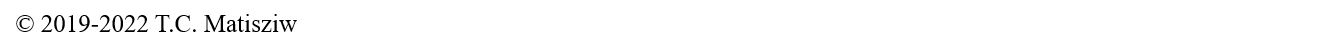